# Overview

**GENERAL THOUGHTS:**  
This notebook includes the following scenarios for Decision Tree Classifier performance evaluation.
- Decision Tree pipeline without overs


**CUSTOM DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

numeric data:
- data imputation: SimpleImputer(strategy='median')
- data scaling: PowerTransformer() using 'log_transform'

categorical data:
- data imputation: SimpleImputer(strategy='most_frequent')
- categorical data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)


**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler

import optuna

import mlflow

import warnings
warnings.filterwarnings('ignore') # 'default'

In [2]:
import os
import sys
import datetime
import yaml
with open('../env_vars.yml', 'r') as file:
        config = yaml.safe_load(file)

# custom imports
sys.path.append(config['project_directory'])
from src import utils

In [3]:
SEED = 42

# Load data

In [4]:
# load data
df = pd.read_csv(f"{config['data_directory']}/output/df_ml.csv", sep='\t')

# prepare data
df['material_number'] = df['material_number'].astype('object')
df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]
df_sub = df_sub.dropna()

In [5]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75913 entries, 0 to 82976
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         75913 non-null  object 
 1   brand                   75913 non-null  object 
 2   product_area            75913 non-null  object 
 3   core_segment            75913 non-null  object 
 4   component               75913 non-null  object 
 5   manufactoring_location  75913 non-null  object 
 6   characteristic_value    75913 non-null  object 
 7   material_weight         75913 non-null  float64
 8   packaging_code          75913 non-null  object 
 9   packaging_category      75913 non-null  object 
dtypes: float64(1), object(9)
memory usage: 6.4+ MB


## Split data into train/test

In [6]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [7]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

# DecisionTree pipeline without oversampling

## DecisionTree (without HPO)

In [ ]:
# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)

In [ ]:
# DEFINE MODEL PIPELINE
# define class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)
# training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.31734170799128397,
                                     1: 0.36451487050208575,
                                     2: 261.76724137931035,
                                     3: 4.904304288136962, 4: 6.821296192294732,
                                     5: 5.540047436599161, 6: 80.54376657824933,
                                     7: 5.614310807062957,
                                     8: 0.7787794462753748,
                                     9: 18.36963097398669,
                                     10: 8.873465809468147,
                                     11: 190.37617554858934,
                                     12: 0.36155696323109165,
                                     13: 0.20638000700054032,
                                     14: 65.44181034482759,
                                     15: 0.9441559652995865,
                                     16: 1.9830851619644723,
                                     17: 1.619596234365416,
                                     18: 1.4979527403680135,
                                     19: 1.5285678328718852,
                                     20: 1.7701926720494359,
                                     21: 2.366257549191506,
                                     22: 0.33957157954183276,
                                     23: 3.394064718046163,
                                     24: 1.2189394243506884,
                                     25: 6.195674352173026,
                                     26: 0.2451578004020701,
                                     27: 1.9982232166359568,
                                     28: 161.08753315649867})

In [10]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = dt_clf.predict(X_test_transformed)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# print classification report for holdout test data
print(classification_report(y_test, preds_y_test_inverse))
report = classification_report(y_test, preds_y_test_inverse, output_dict=True)
f1_score = report['accuracy']
f1_macro = report['macro avg']['f1-score']

                            precision    recall  f1-score   support

   Blister and Insert Card       0.73      0.76      0.74      1650
  Blister and sealed blist       0.70      0.68      0.69      1437
            Book packaging       1.00      0.50      0.67         2
Cardb. Sleeve w - w/o Shr.       0.40      0.50      0.44       107
  Cardboard hanger w/o bag       0.33      0.32      0.33        77
    Carton cover (Lid box)       0.53      0.51      0.52        94
   Carton tube with or w/o       0.00      0.00      0.00         6
                      Case       0.25      0.53      0.34        93
         Corrugated carton       0.73      0.70      0.71       673
        Countertop display       0.79      0.39      0.52        28
                  Envelope       0.51      0.80      0.62        59
          Fabric packaging       0.00      0.00      0.00         3
            Folding carton       0.70      0.65      0.67      1448
              Hanger/ Clip       0.90      0.93

## DecisionTree HPO

### Performe HPO

In [11]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_dt_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_dt_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [ ]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="dt_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=60,
    # timeout=600, 
    show_progress_bar=True
)

[I 2024-11-12 23:49:57,411] A new study created in memory with name: dt_optuna


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2024-11-12 23:49:58,503] Trial 0 finished with value: 0.6167338867022907 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6167338867022907.
[I 2024-11-12 23:49:58,962] Trial 1 finished with value: 0.5373504860646997 and parameters: {'max_depth': 28, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.6167338867022907.
[I 2024-11-12 23:49:59,340] Trial 2 finished with value: 0.5275029645269681 and parameters: {'max_depth': 100, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.6167338867022907.
[I 2024-11-12 23:49:59,558] Trial 3 finished with value: 0.0806422202280945 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.6167338867022907.
[I 2024-11-12 23:50:00,029] Trial 4 finished with value: 0.5354450845453272 and parameters: {'max_depth': 32, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.

In [13]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  60
Best trial:
  Performance:  0.6819846637620709
  Best trial: {'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [14]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,state
0,0,0.616734,2024-11-12 23:49:57.597150,2024-11-12 23:49:58.503611,0 days 00:00:00.906461,entropy,50,2,COMPLETE
1,1,0.537350,2024-11-12 23:49:58.508644,2024-11-12 23:49:58.961857,0 days 00:00:00.453213,gini,28,8,COMPLETE
2,2,0.527503,2024-11-12 23:49:58.963509,2024-11-12 23:49:59.340018,0 days 00:00:00.376509,gini,100,7,COMPLETE
3,3,0.080642,2024-11-12 23:49:59.341546,2024-11-12 23:49:59.558410,0 days 00:00:00.216864,gini,4,8,COMPLETE
4,4,0.535445,2024-11-12 23:49:59.563987,2024-11-12 23:50:00.029267,0 days 00:00:00.465280,gini,32,6,COMPLETE


In [15]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [16]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [17]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [18]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [19]:
best_trial.params

{'max_depth': 100, 'min_samples_leaf': 1, 'criterion': 'entropy'}

In [ ]:
# define best model
best_params = best_trial.params

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [ ]:
# perform cross validation on a given model to analyze the degree of overfitting and underfitting.
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

mean train performance: 1.0
mean test performance: 0.5650043390555041


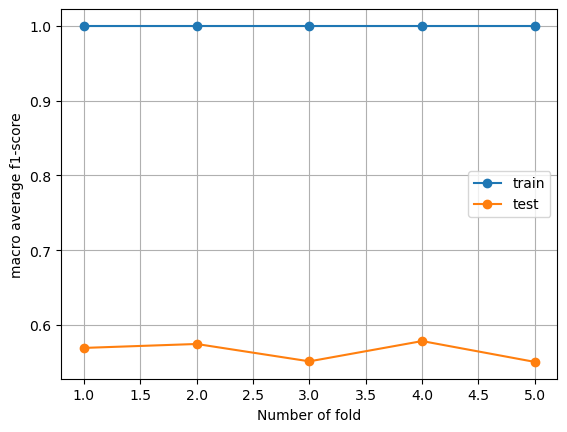

In [22]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='C0', label='train')
plt.plot(folds, performance_test, 'o-', color='C1', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [23]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# print classification report for holdout test data
print(classification_report(y_test, preds_y_test_inverse))
report = classification_report(y_test, preds_y_test_inverse, output_dict=True)
f1_score = report['accuracy']
f1_macro = report['macro avg']['f1-score']

                            precision    recall  f1-score   support

   Blister and Insert Card       0.73      0.74      0.74      1650
  Blister and sealed blist       0.64      0.70      0.67      1437
            Book packaging       0.08      0.50      0.13         2
Cardb. Sleeve w - w/o Shr.       0.51      0.54      0.52       107
  Cardboard hanger w/o bag       0.47      0.52      0.49        77
    Carton cover (Lid box)       0.44      0.37      0.40        94
   Carton tube with or w/o       0.33      0.17      0.22         6
                      Case       0.38      0.62      0.47        93
         Corrugated carton       0.58      0.48      0.53       673
        Countertop display       0.59      0.61      0.60        28
                  Envelope       0.40      0.83      0.54        59
          Fabric packaging       0.00      0.00      0.00         3
            Folding carton       0.71      0.70      0.71      1448
              Hanger/ Clip       0.89      0.84

### Deeper analysis of DecisionTreeClassifier

In [24]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Tube,Tube,1.0
1,Blister and Insert Card,Blister and Insert Card,1.0
2,Tube,Tube,1.0
3,TightPack,TightPack,1.0
4,Corrugated carton,Trap Card,1.0
5,Unpacked,Unpacked,1.0
6,Hanger/ Clip,Hanger/ Clip,1.0
7,Blister and sealed blist,Trap Folding Card,1.0
8,Plastic Cassette,Plastic Cassette,1.0
9,Blister and sealed blist,Blister and Insert Card,1.0


In [25]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test


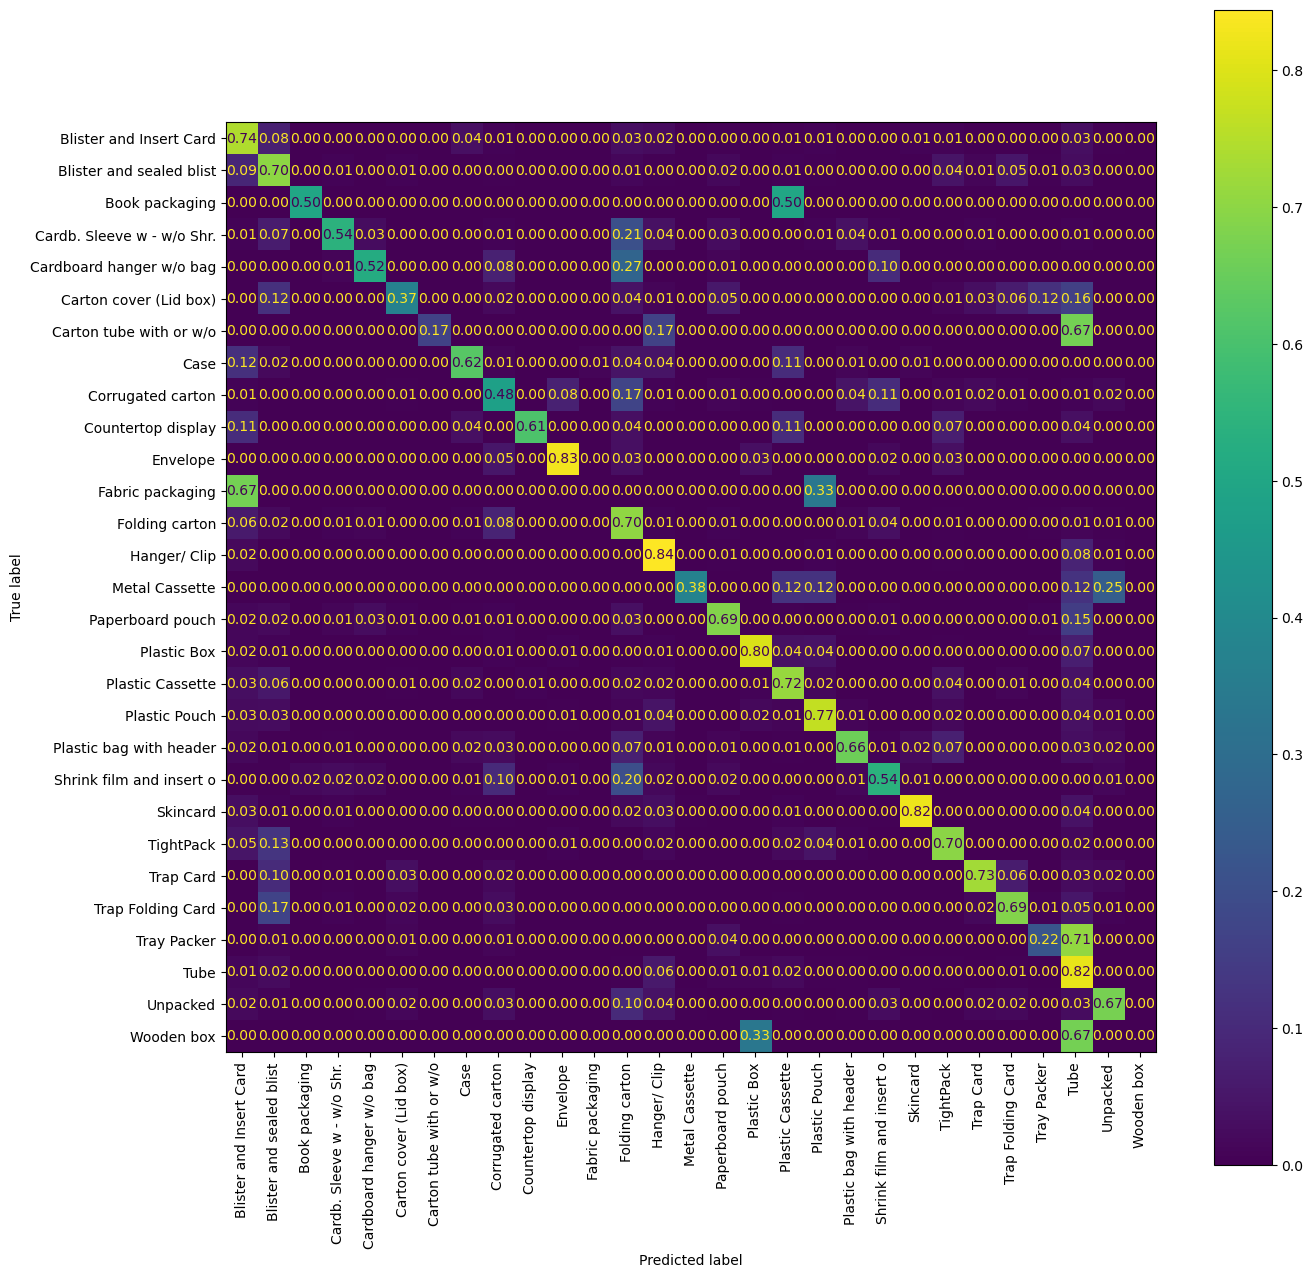

In [ ]:
# create confusion matrix
# confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

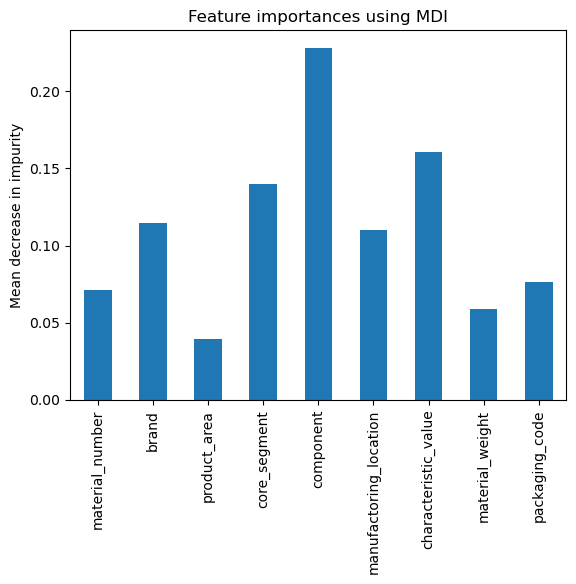

In [27]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# DecisionTree pipeline with oversampling

<Figure size 1000x500 with 0 Axes>

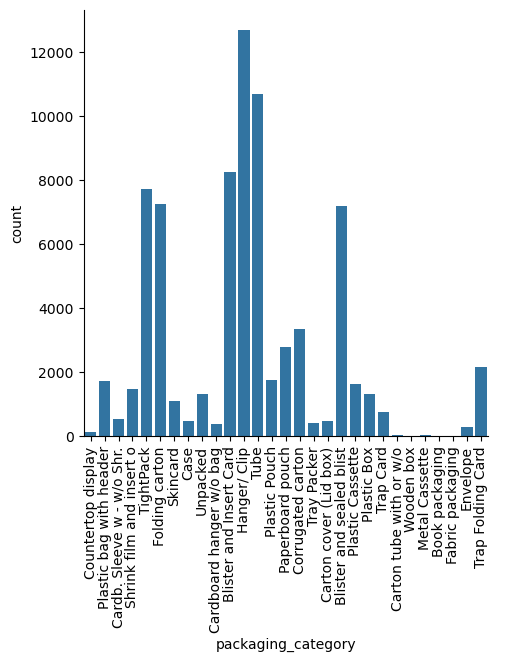

In [28]:
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

In [29]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'Metal Cassette': 100,
    'Carton tube with or w/o': 100,
    'Wooden box': 100,
    'Fabric packaging': 100,
    'Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X, y = oversampler.fit_resample(X, y)

distribution_classes = y.value_counts()
print('Class distribution after oversampling')
print(distribution_classes.to_dict())

# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y,
    # random_state=SEED
)

Class distribution before oversmapling
{'Hanger/ Clip': 12684, 'Tube': 10678, 'Blister and Insert Card': 8249, 'TightPack': 7709, 'Folding carton': 7240, 'Blister and sealed blist': 7182, 'Corrugated carton': 3362, 'Paperboard pouch': 2773, 'Trap Folding Card': 2147, 'Plastic Pouch': 1747, 'Plastic bag with header': 1712, 'Plastic Cassette': 1616, 'Shrink film and insert o': 1479, 'Plastic Box': 1320, 'Unpacked': 1310, 'Skincard': 1106, 'Trap Card': 771, 'Cardb. Sleeve w - w/o Shr.': 534, 'Carton cover (Lid box)': 472, 'Case': 466, 'Tray Packer': 423, 'Cardboard hanger w/o bag': 384, 'Envelope': 295, 'Countertop display': 142, 'Metal Cassette': 40, 'Carton tube with or w/o': 32, 'Wooden box': 16, 'Fabric packaging': 14, 'Book packaging': 10}
Class distribution after oversampling
{'Hanger/ Clip': 12684, 'Tube': 10678, 'Blister and Insert Card': 8249, 'TightPack': 7709, 'Folding carton': 7240, 'Blister and sealed blist': 7182, 'Corrugated carton': 3362, 'Paperboard pouch': 2773, 'Trap Fo

## DecisionTree (without HPO)

In [ ]:
# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on separate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)


In [ ]:
# DEFINE MODEL PIPELINE
# define class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))
# model
dt_clf = DecisionTreeClassifier(
    # n_estimators=10,
    class_weight=class_weight_dict,
    # random_state=SEED
)
# training
dt_clf.fit(X_train_transformed, y_train_transformed)

DecisionTreeClassifier(class_weight={0: 0.31896159815228015,
                                     1: 0.366375558956814,
                                     2: 26.310344827586206,
                                     3: 4.929338609383833, 4: 6.856115915983376,
                                     5: 5.568326947637292,
                                     6: 26.310344827586206,
                                     7: 5.642969400018489,
                                     8: 0.7827547735986972,
                                     9: 18.463399879007863, 10: 8.9187609585038,
                                     11: 26.310344827586206,
                                     12: 0.3634025528672128,
                                     13: 0.20743348637103542,
                                     14: 26.310344827586206,
                                     15: 0.9489754671807469,
                                     16: 1.9932079414838035,
                                     17: 1.6278635624183269,
                                     18: 1.5055991317645898,
                                     19: 1.5363705008809463,
                                     20: 1.7792287288308508,
                                     21: 2.3783362556010132,
                                     22: 0.3413049434420134,
                                     23: 3.4113899290225227,
                                     24: 1.2251615752077396,
                                     25: 6.227300550907978,
                                     26: 0.2464092233911141,
                                     27: 2.0084232692813897,
                                     28: 26.310344827586206})

In [32]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = dt_clf.predict(X_test_transformed)

preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# print classification report for holdout test data
print(classification_report(y_test, preds_y_test_dt_inverse))
report = classification_report(y_test, preds_y_test_dt_inverse, output_dict=True)
f1_score = report['accuracy']
f1_macro = report['macro avg']['f1-score']

                            precision    recall  f1-score   support

   Blister and Insert Card       0.68      0.75      0.71      1650
  Blister and sealed blist       0.76      0.67      0.71      1437
            Book packaging       1.00      1.00      1.00        20
Cardb. Sleeve w - w/o Shr.       0.58      0.47      0.52       107
  Cardboard hanger w/o bag       0.45      0.40      0.42        77
    Carton cover (Lid box)       0.45      0.34      0.39        94
   Carton tube with or w/o       0.79      0.95      0.86        20
                      Case       0.20      0.39      0.27        93
         Corrugated carton       0.74      0.68      0.71       673
        Countertop display       0.89      0.61      0.72        28
                  Envelope       0.84      0.88      0.86        59
          Fabric packaging       0.87      1.00      0.93        20
            Folding carton       0.67      0.64      0.65      1448
              Hanger/ Clip       0.93      0.93

## DecisionTree HPO

### Performe HPO

In [33]:
class OptunaObjective(object):

    def __init__(self, scoring, X: np.array, y: np.array):
        self.scoring=scoring
        self.X=X
        self.y=y

    def __call__(self, trial: optuna.Trial) -> float:
        
        # joblib.dump(study, 'study.pkl')

        hp_dt_optuna = {
            'max_depth': trial.suggest_categorical('max_depth', [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 50, 60, 80, 100]), # Maximum number of levels in tree
            # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']), # Number of features to consider at every split
            # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 14), # Minimum number of samples required to split a node
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8), # Minimum number of samples required at each leaf node
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), # function to measure the quality of a split
        }

        # Generate train/val sets randomly for each trial to prevent overfitting
        X_train, X_val, y_train, y_val = train_test_split(
            self.X, self.y, test_size=0.2, stratify=self.y, random_state=None
        )

        # class_weights
        class_weights = compute_sample_weight(
            class_weight='balanced',
            y=y_train
        )
        class_weight_dict = dict(enumerate(class_weights))

        # model
        model = DecisionTreeClassifier(
            # n_estimators=1000,
            class_weight=class_weight_dict,
            **hp_dt_optuna,
            # random_state=SEED
        )

        # fit model
        # NOTE: cross_val within an HPO study is not suggested since it is an extra layer of computational complexity;
        #       often this is not needed OR it is anyways somehow covered by the optimization strategy, e.g. Bayesian
        model.fit(X_train, y_train)
        
        # eval performance
        preds_y_val = model.predict(X_val)
        clf_report = classification_report(y_val, preds_y_val, output_dict=True)

        return clf_report['macro avg']['f1-score']

In [ ]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    scoring="f1_macro",
    X=X_train_transformed,
    y=y_train_transformed,
)

# define and run study for optimization
# define search strategy: TPESampler = bayesian optimizer with a tree-structured Parzen Estimator
study = optuna.create_study(
    study_name="dt_optuna",
    # storage=optuna_storage,
    # load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=60,
    # timeout=600, 
    show_progress_bar=True
)

[I 2024-11-12 23:51:02,484] A new study created in memory with name: dt_optuna


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2024-11-12 23:51:03,453] Trial 0 finished with value: 0.7410624462170324 and parameters: {'max_depth': 50, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7410624462170324.
[I 2024-11-12 23:51:04,321] Trial 1 finished with value: 0.63313421042906 and parameters: {'max_depth': 28, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.7410624462170324.
[I 2024-11-12 23:51:04,843] Trial 2 finished with value: 0.6383802713608261 and parameters: {'max_depth': 100, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 0 with value: 0.7410624462170324.
[I 2024-11-12 23:51:05,083] Trial 3 finished with value: 0.13961149644256357 and parameters: {'max_depth': 4, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.7410624462170324.
[I 2024-11-12 23:51:05,568] Trial 4 finished with value: 0.653818869762386 and parameters: {'max_depth': 32, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.74

In [35]:
# print optimization results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

Number of finished trials:  60
Best trial:
  Performance:  0.7712593570079396
  Best trial: {'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}


### Analyse HPO
Auswertung Optuna study

In [36]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_min_samples_leaf,state
0,0,0.741062,2024-11-12 23:51:02.526307,2024-11-12 23:51:03.453691,0 days 00:00:00.927384,entropy,50,2,COMPLETE
1,1,0.633134,2024-11-12 23:51:03.455211,2024-11-12 23:51:04.321272,0 days 00:00:00.866061,gini,28,8,COMPLETE
2,2,0.638380,2024-11-12 23:51:04.324754,2024-11-12 23:51:04.842567,0 days 00:00:00.517813,gini,100,7,COMPLETE
3,3,0.139611,2024-11-12 23:51:04.853505,2024-11-12 23:51:05.083121,0 days 00:00:00.229616,gini,4,8,COMPLETE
4,4,0.653819,2024-11-12 23:51:05.085912,2024-11-12 23:51:05.568623,0 days 00:00:00.482711,gini,32,6,COMPLETE


In [37]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [38]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [39]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [40]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [41]:
best_trial.params

{'max_depth': 50, 'min_samples_leaf': 1, 'criterion': 'entropy'}

In [ ]:
# Define best model
best_params = best_trial.params

# class_weights
class_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_model = DecisionTreeClassifier(
    # n_estimators=1000,
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

In [ ]:
# perform cross validation on a given model to analyze the degree of overfitting and underfitting.
performance_train, performance_test, kf = utils.check_model_learning_CV(
    n_splits=5,
    model=best_model,
    X=X,
    y=y,
    preprocess_pipeline=preprocess_pipeline,
    label_encoder=label_encoder,
    # random_state=SEED
)

mean train performance: 0.9999943699652576
mean test performance: 0.706069993362093


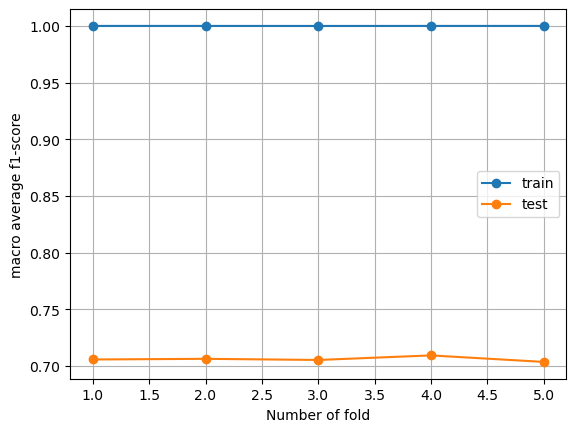

In [44]:
print("mean train performance: {}".format(performance_train.mean()))
print("mean test performance: {}".format(performance_test.mean()))

folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, performance_train, 'o-', color='C0', label='train')
plt.plot(folds, performance_test, 'o-', color='C1', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('macro average f1-score')
plt.show()

In [45]:
# final performance evaluation of best model

best_model.fit(X_train_transformed, y_train_transformed)

X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test = best_model.predict(X_test_transformed)

# yprobs2d = best_model.predict_proba(Xtest)
# model_eval_bin(f'{model_name}+{hpo_name}', ytest, ypreds, yprobs2d, show_plots=False)

preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# print classification report for holdout test data
print(classification_report(y_test, preds_y_test_inverse))
report = classification_report(y_test, preds_y_test_inverse, output_dict=True)
f1_score = report['accuracy']
f1_macro = report['macro avg']['f1-score']

                            precision    recall  f1-score   support

   Blister and Insert Card       0.71      0.77      0.74      1650
  Blister and sealed blist       0.70      0.73      0.72      1437
            Book packaging       1.00      0.40      0.57        20
Cardb. Sleeve w - w/o Shr.       0.42      0.34      0.37       107
  Cardboard hanger w/o bag       0.58      0.39      0.47        77
    Carton cover (Lid box)       0.77      0.18      0.29        94
   Carton tube with or w/o       0.71      0.60      0.65        20
                      Case       0.47      0.51      0.49        93
         Corrugated carton       0.56      0.61      0.59       673
        Countertop display       0.75      0.64      0.69        28
                  Envelope       0.62      0.59      0.61        59
          Fabric packaging       0.90      0.90      0.90        20
            Folding carton       0.65      0.63      0.64      1448
              Hanger/ Clip       0.90      0.89

### Track performance using MLflow

In [55]:
# NOTE: Change to a meaningful name
EXPERIMENT_NAME = "AutoPackagingCategories"
RUN_NAME = "run_DecisionTree"

with open('../env_vars.yml', 'r') as file:
    env_vars = yaml.safe_load(file)

project_dir = env_vars['project_directory']
os.makedirs(project_dir + '/mlruns', exist_ok=True)

mlflow.set_tracking_uri("file://" + project_dir + "/mlruns")

try:
    experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
    EXPERIMENT_ID = experiment.experiment_id
except AttributeError:
    EXPERIMENT_ID = mlflow.create_experiment(
        EXPERIMENT_NAME,
        # mlflow.set_artifact_uri("file://" + project_dir + "/artifacts/")
    )

current_time = datetime.datetime.now()
time_stamp = str(current_time)
# NOTE: Change to a meaningful name for the single trial
# exp_run_name = f"run_MeaningfulTrialName_{time_stamp}"
exp_run_name = f"{RUN_NAME}_{time_stamp}"

# Start MLflow
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=exp_run_name) as run:

    # Retrieve run id
    RUN_ID = run.info.run_id

    # Track parameters
    # track pipeline configs: preprocessing_pipeline
    mlflow.log_dict(
        {'oversampler': type(oversampler), 'label_encoder': type(label_encoder)} | preprocess_pipeline.named_transformers_,
        "preprocessing_pipeline.json"
    )

    # mode specfic parameters
    mlflow.log_param('model', f'{type(best_model)}')
    mlflow.log_param('model_configs', best_model.get_params())
    
    # mode specfic parameters
    
    # Track metrics
    # mlflow.log_metric("Train_f1_macro", train_f1_macro)
    # mlflow.log_metric("TestVal_f1_macro", test_f1_macro)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.log_metric("Report_Test_f1_score", f1_score)
    mlflow.log_metric("Report_Test_f1_macro", f1_macro)

    # Track model
    # mlflow.sklearn.log_model(clf, "classifier")


2024/11/13 00:11:52 WARNING mlflow.utils.validation: Param value '{'ccp_alpha': 0.0, 'class_weight': {0: 0.2464092233911141, 1: 0.20743348637103542, 2: 0.948975467180...' (1645738 characters) is truncated to 6000 characters to meet the length limit.


### Deeper analysis of DecisionTreeClassifier

In [47]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,1.0
1,Hanger/ Clip,Hanger/ Clip,1.0
2,Blister and sealed blist,Tube,1.0
3,Blister and sealed blist,Blister and sealed blist,1.0
4,Hanger/ Clip,Hanger/ Clip,1.0
5,Hanger/ Clip,Hanger/ Clip,1.0
6,Tube,Tube,1.0
7,TightPack,TightPack,1.0
8,Blister and Insert Card,Case,1.0
9,Plastic Pouch,Plastic Pouch,1.0


In [48]:
df_y_test.loc[
    df_y_test.y_test == 'H1 Wooden box'
].head(30)

,y_test,preds_y_test,proba_preds_y_test


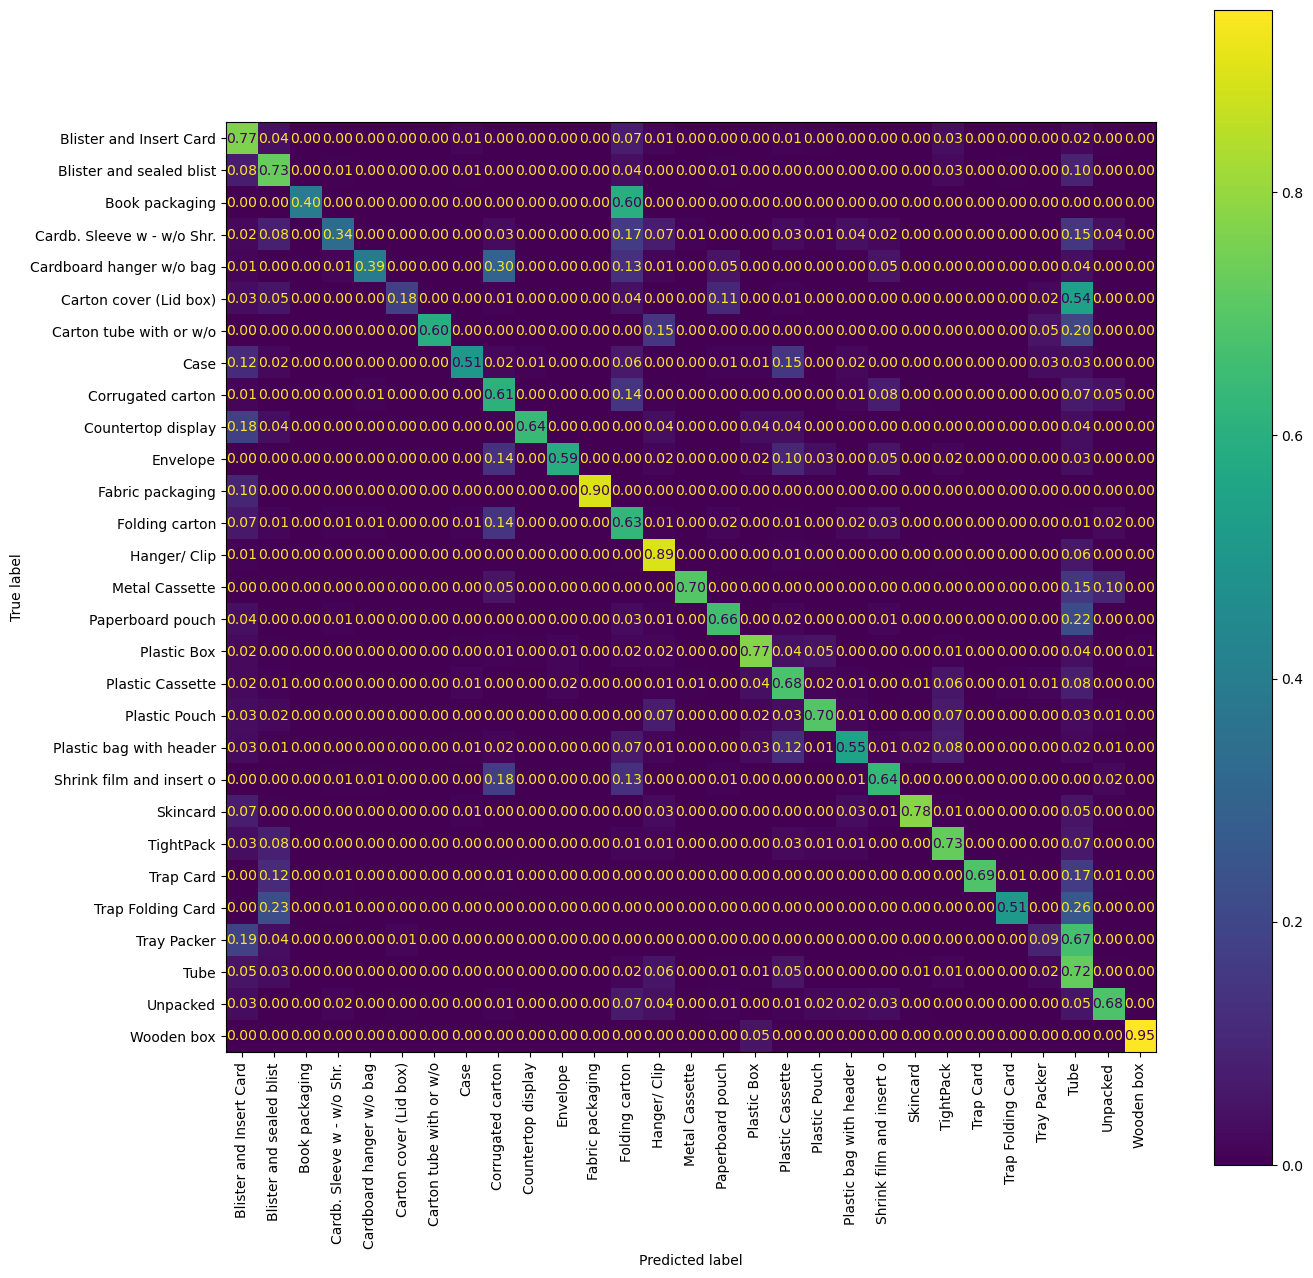

In [49]:
# Create the confusion matrix
# confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

Text(0, 0.5, 'Mean decrease in impurity')

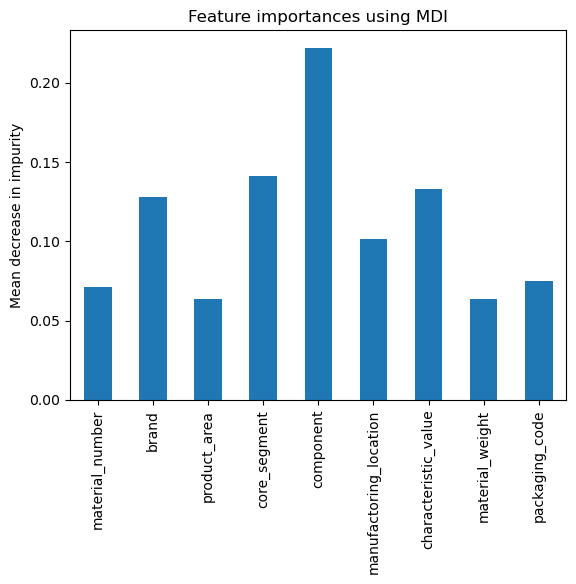

In [50]:
importances = best_model.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns.to_list())

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

# Threshold analysis best model

Findings threshold analysis: since the decision tree does not provide probabilty a threshold analysis does not make any sense

In [51]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,1.0
1,Hanger/ Clip,Hanger/ Clip,1.0
2,Blister and sealed blist,Tube,1.0
3,Blister and sealed blist,Blister and sealed blist,1.0
4,Hanger/ Clip,Hanger/ Clip,1.0
5,Hanger/ Clip,Hanger/ Clip,1.0
6,Tube,Tube,1.0
7,TightPack,TightPack,1.0
8,Blister and Insert Card,Case,1.0
9,Plastic Pouch,Plastic Pouch,1.0


In [52]:
df_y_test_threshold = df_y_test.copy()
df_y_test_threshold.head()

,y_test,preds_y_test,proba_preds_y_test
0,Hanger/ Clip,Hanger/ Clip,1.0
1,Hanger/ Clip,Hanger/ Clip,1.0
2,Blister and sealed blist,Tube,1.0
3,Blister and sealed blist,Blister and sealed blist,1.0
4,Hanger/ Clip,Hanger/ Clip,1.0


In [53]:
# threshhold None
df_y_test_threshold_X = df_y_test_threshold.copy()

# print classification report for holdout test data
print(classification_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test))
report = classification_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test, output_dict=True)

                            precision    recall  f1-score   support

   Blister and Insert Card       0.71      0.77      0.74      1650
  Blister and sealed blist       0.70      0.73      0.72      1437
            Book packaging       1.00      0.40      0.57        20
Cardb. Sleeve w - w/o Shr.       0.42      0.34      0.37       107
  Cardboard hanger w/o bag       0.58      0.39      0.47        77
    Carton cover (Lid box)       0.77      0.18      0.29        94
   Carton tube with or w/o       0.71      0.60      0.65        20
                      Case       0.47      0.51      0.49        93
         Corrugated carton       0.56      0.61      0.59       673
        Countertop display       0.75      0.64      0.69        28
                  Envelope       0.62      0.59      0.61        59
          Fabric packaging       0.90      0.90      0.90        20
            Folding carton       0.65      0.63      0.64      1448
              Hanger/ Clip       0.90      0.89

In [54]:
# threshhold 95
df_y_test_threshold_X = df_y_test_threshold.loc[
    df_y_test_threshold.proba_preds_y_test >= 0.95
]

# print classification report for holdout test data
print(classification_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test))
report = classification_report(df_y_test_threshold_X.y_test, df_y_test_threshold_X.preds_y_test, output_dict=True)

                            precision    recall  f1-score   support

   Blister and Insert Card       0.71      0.77      0.74      1650
  Blister and sealed blist       0.70      0.73      0.72      1437
            Book packaging       1.00      0.40      0.57        20
Cardb. Sleeve w - w/o Shr.       0.42      0.34      0.37       107
  Cardboard hanger w/o bag       0.58      0.39      0.47        77
    Carton cover (Lid box)       0.77      0.18      0.29        94
   Carton tube with or w/o       0.71      0.60      0.65        20
                      Case       0.47      0.51      0.49        93
         Corrugated carton       0.56      0.61      0.59       673
        Countertop display       0.75      0.64      0.69        28
                  Envelope       0.62      0.59      0.61        59
          Fabric packaging       0.90      0.90      0.90        20
            Folding carton       0.65      0.63      0.64      1448
              Hanger/ Clip       0.90      0.89